In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
train_data = pd.read_csv('/content/train_FD001.txt', sep=' ', header=None)
test_data = pd.read_csv('/content/test_FD001.txt', sep=' ', header=None)
rul_data = pd.read_csv('/content/RUL_FD001.txt', sep=' ', header=None)

# Define the column names
columns = ['unit_number', 'time', 'operational_setting_1',
           'operational_setting_2', 'operational_setting_3'] + \
          [f'sensor_{i}' for i in range(1, 21)] + \
          ['extra_1', 'extra_2', 'extra_3']  # For the last 3 columns

# Assign the column names
train_data.columns = columns
test_data.columns = columns

print(f"Train Data Columns: {len(train_data.columns)}")
print(train_data.columns)

print(f"Test Data Columns: {len(test_data.columns)}")
print(test_data.columns)

FileNotFoundError: [Errno 2] No such file or directory: '/content/train_FD001.txt'

In [ ]:
print (test_data.head())

   unit_number  time  operational_setting_1  operational_setting_2  \
0            1     1                 0.0023                 0.0003   
1            1     2                -0.0027                -0.0003   
2            1     3                 0.0003                 0.0001   
3            1     4                 0.0042                 0.0000   
4            1     5                 0.0014                 0.0000   

   operational_setting_3  sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  \
0                  100.0    518.67    643.02   1585.29   1398.21     14.62   
1                  100.0    518.67    641.71   1588.45   1395.42     14.62   
2                  100.0    518.67    642.46   1586.94   1401.34     14.62   
3                  100.0    518.67    642.44   1584.12   1406.42     14.62   
4                  100.0    518.67    642.51   1587.19   1401.92     14.62   

   ...  sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  \
0  ...    8125.55     8.4052      

In [ ]:
print (train_data.head())

   unit_number  time  operational_setting_1  operational_setting_2  \
0            1     1                -0.0007                -0.0004   
1            1     2                 0.0019                -0.0003   
2            1     3                -0.0043                 0.0003   
3            1     4                 0.0007                 0.0000   
4            1     5                -0.0019                -0.0002   

   operational_setting_3  sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  \
0                  100.0    518.67    641.82   1589.70   1400.60     14.62   
1                  100.0    518.67    642.15   1591.82   1403.14     14.62   
2                  100.0    518.67    642.35   1587.99   1404.20     14.62   
3                  100.0    518.67    642.35   1582.79   1401.87     14.62   
4                  100.0    518.67    642.37   1582.85   1406.22     14.62   

   ...  sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  \
0  ...    8138.62     8.4195      

In [ ]:
# Calculate RUL for training set
train_data['RUL'] = train_data.groupby('unit_number')['time'].transform(lambda x: x.max() - x)

# Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data.iloc[:, 2:-1] = scaler.fit_transform(train_data.iloc[:, 2:-1])
test_data.iloc[:, 2:] = scaler.transform(test_data.iloc[:, 2:])


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
<ipython-input-35-a1a1eb6071c4>:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.33333333 0.33333333 0.16666667 ... 0.83333333 0.58333333 0.66666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data.iloc[:, 2:-1] = scaler.fit_transform(train_data.iloc[:, 2:-1])
<ipython-input-35-a1a1eb6071c4>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.33333333 0.41666667 0.41666667 ... 0.58333333 0.58333333 0.66666667]' has dtype incompatible with int64, please explicitly cast t

In [ ]:
X = train_data.iloc[:, 2:-1]
y = train_data['RUL']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

# Validation
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("Validation RMSE:", rmse)


Validation RMSE: 41.60638416599145


In [ ]:
X_test = test_data.iloc[:, 2:]
predicted_rul = model.predict(X_test)

# Ensure predictions are for the last cycle of each unit
last_cycle_indices = test_data.groupby('unit_number')['time'].idxmax()
predicted_rul = predicted_rul[last_cycle_indices]
true_rul = rul_data.values
print(f"True RUL length: {len(true_rul)}")
print(f"Predicted RUL length: {len(predicted_rul)}")



True RUL length: 100
Predicted RUL length: 100


In [ ]:
import numpy as np

# Check for NaN in true_rul
print(f"NaN in true_rul: {np.isnan(true_rul).sum()}")

# Check for NaN in predicted_rul
print(f"NaN in predicted_rul: {np.isnan(predicted_rul).sum()}")



NaN in true_rul: 100
NaN in predicted_rul: 0


In [ ]:
# Replace NaN with mean or remove rows where true_rul is NaN
valid_indices = ~np.isnan(true_rul)
true_rul = true_rul[valid_indices]

In [ ]:
print(f"True RUL length: {len(true_rul)}")
print(f"Predicted RUL length: {len(predicted_rul)}")


True RUL length: 100
Predicted RUL length: 100


Test RMSE: 33.35830527769659


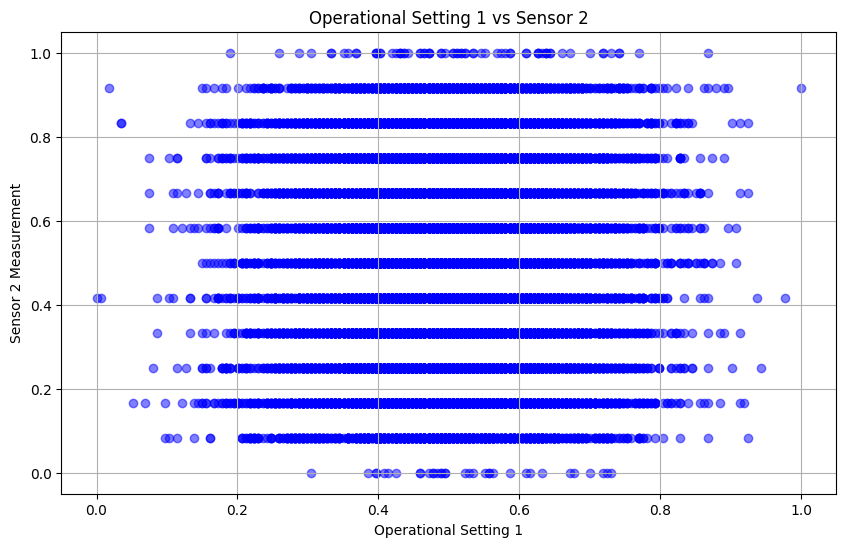

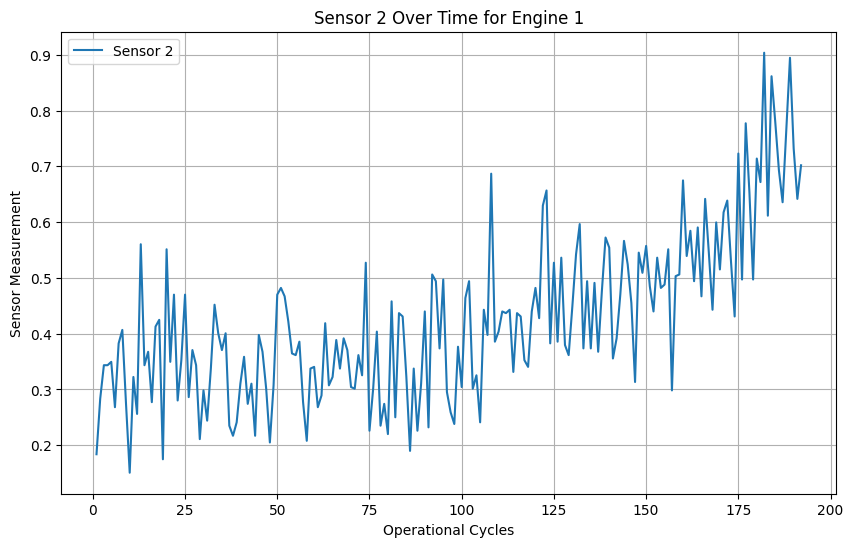

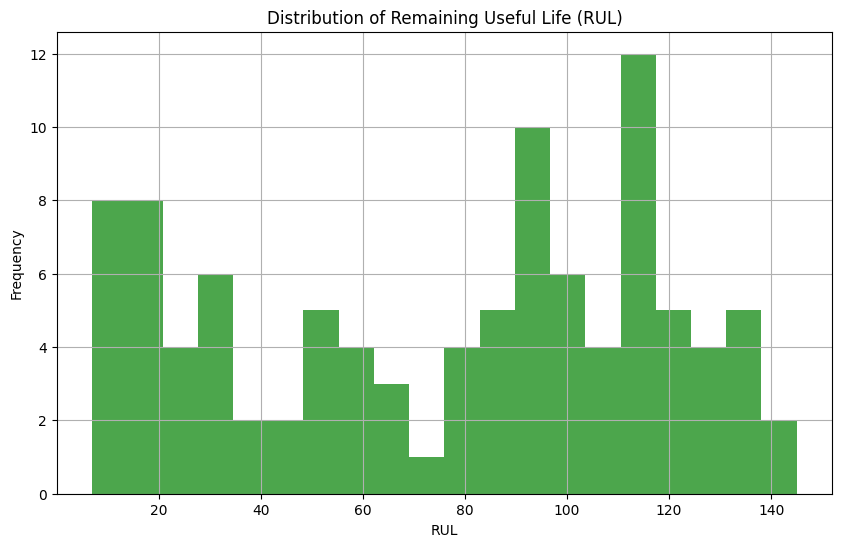

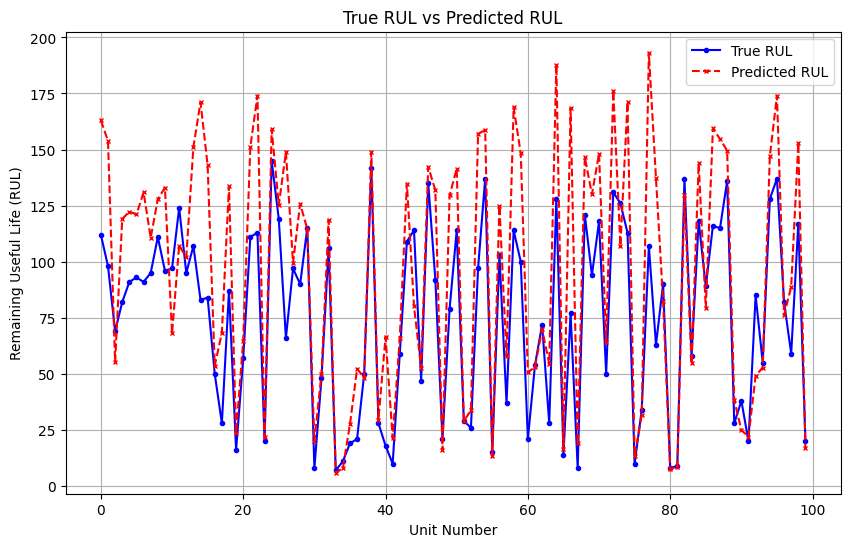

In [ ]:
from sklearn.metrics import mean_squared_error
rmse_test = np.sqrt(mean_squared_error(true_rul, predicted_rul))
print("Test RMSE:", rmse_test)
# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(train_data['operational_setting_1'], train_data['operational_setting_2'], alpha=0.5, color='b')
plt.title('Operational Setting 1 vs Sensor 2')
plt.xlabel('Operational Setting 1')
plt.ylabel('Sensor 2 Measurement')
plt.grid()
plt.show()
# Filter data for a single engine
engine_1_data = train_data[train_data['unit_number'] == 1]
# Plot
plt.figure(figsize=(10, 6))
plt.plot(engine_1_data['time'], engine_1_data['sensor_2'], label='Sensor 2')
plt.title('Sensor 2 Over Time for Engine 1')
plt.xlabel('Operational Cycles')
plt.ylabel('Sensor Measurement')
plt.legend()
plt.grid()
plt.show()
# Plot
plt.figure(figsize=(10,6))
plt.hist(rul_data[0], bins=20, color='g', alpha=0.7)
plt.title('Distribution of Remaining Useful Life (RUL)')
plt.xlabel('RUL')
plt.ylabel('Frequency')
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(true_rul, label='True RUL', color='blue', linestyle='-', marker='o', markersize=3)
plt.plot(predicted_rul, label='Predicted RUL', color='red', linestyle='--', marker='x', markersize=3)
plt.xlabel('Unit Number')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title('True RUL vs Predicted RUL')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Prepare data for LSTM
def create_sequences(data, sequence_length, features, target):
    X, y = [], []
    for unit in data['unit_number'].unique():
        unit_data = data[data['unit_number'] == unit]
        for i in range(len(unit_data) - sequence_length):
            seq_X = unit_data.iloc[i:i + sequence_length, features].values
            seq_y = unit_data.iloc[i + sequence_length - 1][target]
            X.append(seq_X)
            y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
sequence_length = 30
features = list(range(2, 26))  # Column indices for sensor data
target = -1  # Column index for 'RUL'

In [ ]:
X_train, y_train = create_sequences(train_data, sequence_length, features, target)

# Prepare test data (last cycle of each unit)
X_test, y_test = [], []
for unit in test_data['unit_number'].unique():
    unit_data = test_data[test_data['unit_number'] == unit]
    if len(unit_data) >= sequence_length:
        X_test.append(unit_data.iloc[-sequence_length:, features].values)
        y_test.append(rul_data.iloc[unit - 1, 0])  # Map test RUL data to units
X_test, y_test = np.array(X_test), np.array(y_test)


<ipython-input-13-b4437d7fa320>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  seq_y = unit_data.iloc[i + sequence_length - 1][target]


In [ ]:
# Build LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM

model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, len(features))),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 4662.2881 - val_loss: 2854.7622
Epoch 2/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 1577.2084 - val_loss: 3265.9067
Epoch 3/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 1465.5916 - val_loss: 2812.9126
Epoch 4/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 1422.3400 - val_loss: 2482.9045
Epoch 5/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 1272.8239 - val_loss: 2331.2871
Epoch 6/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 1240.1497 - val_loss: 1883.1399
Epoch 7/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 1169.9999 - val_loss: 1870.5222
Epoch 8/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 1126.0499 - val_loss: 1927.5375
Epoch 9/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 1078.9833 - val_loss: 1838.5699
Epoch 10/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 1051.0671 - val_loss: 2151.1003
Epoch 11/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 1046

In [ ]:
# Evaluate on test set
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", rmse)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Test RMSE: 33.491614359744965


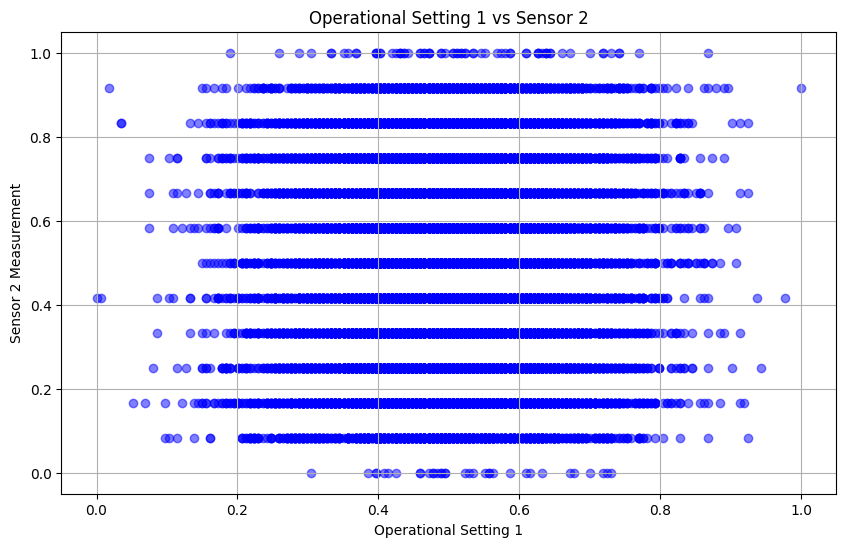

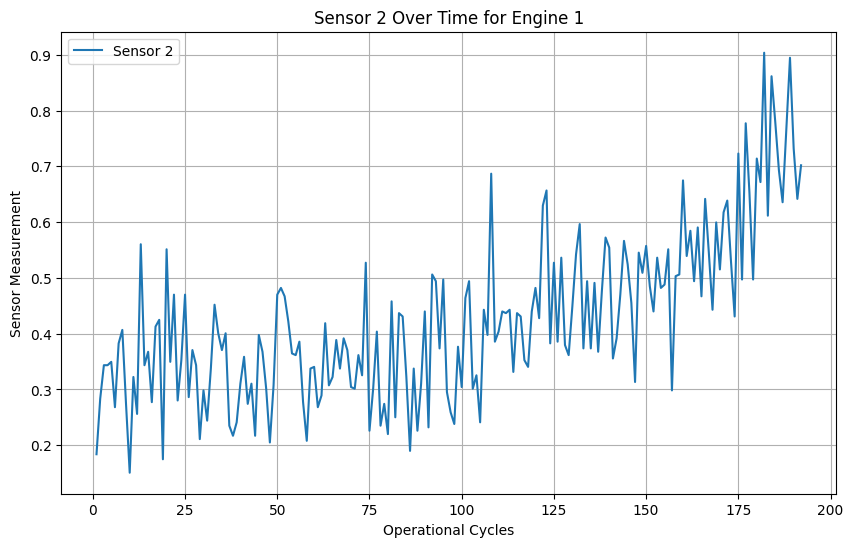

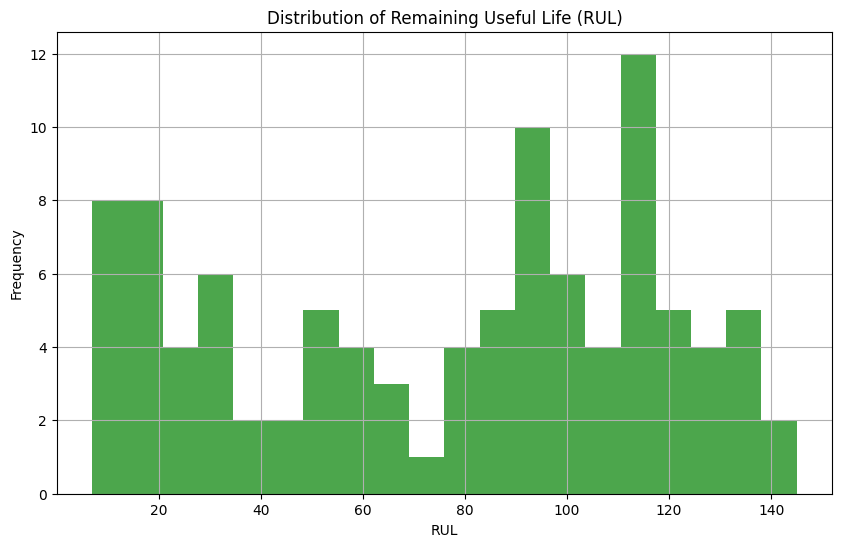

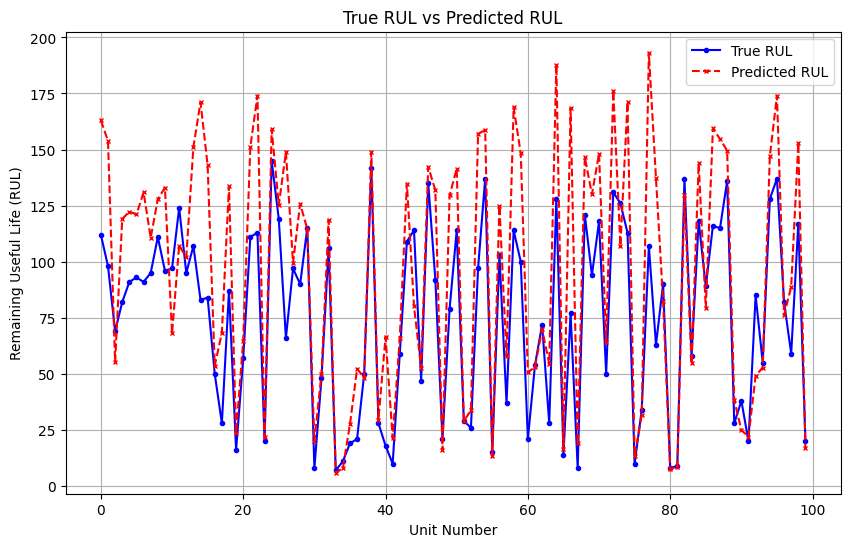

In [ ]:

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(train_data['operational_setting_1'], train_data['operational_setting_2'], alpha=0.5, color='b')
plt.title('Operational Setting 1 vs Sensor 2')
plt.xlabel('Operational Setting 1')
plt.ylabel('Sensor 2 Measurement')
plt.grid()
plt.show()
# Filter data for a single engine
engine_1_data = train_data[train_data['unit_number'] == 1]
# Plot
plt.figure(figsize=(10, 6))
plt.plot(engine_1_data['time'], engine_1_data['sensor_2'], label='Sensor 2')
plt.title('Sensor 2 Over Time for Engine 1')
plt.xlabel('Operational Cycles')
plt.ylabel('Sensor Measurement')
plt.legend()
plt.grid()
plt.show()
# Plot
plt.figure(figsize=(10,6))
plt.hist(rul_data[0], bins=20, color='g', alpha=0.7)
plt.title('Distribution of Remaining Useful Life (RUL)')
plt.xlabel('RUL')
plt.ylabel('Frequency')
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(true_rul, label='True RUL', color='blue', linestyle='-', marker='o', markersize=3)
plt.plot(predicted_rul, label='Predicted RUL', color='red', linestyle='--', marker='x', markersize=3)
plt.xlabel('Unit Number')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title('True RUL vs Predicted RUL')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Prepare data for LSTM
def create_sequences(data, sequence_length, features, target):
    X, y = [], []
    for unit in data['unit_number'].unique():
        unit_data = data[data['unit_number'] == unit]
        for i in range(len(unit_data) - sequence_length):
            seq_X = unit_data.iloc[i:i + sequence_length, features].values
            seq_y = unit_data.iloc[i + sequence_length - 1][target]
            X.append(seq_X)
            y.append(seq_y)
    return np.array(X), np.array(y)
sequence_length = 30
features = list(range(2, 26))  # Column indices for sensor data
target = -1  # Column index for 'RUL'
X_train, y_train = create_sequences(train_data, sequence_length, features, target)

# Prepare test data (last cycle of each unit)
X_test, y_test = [], []
for unit in test_data['unit_number'].unique():
    unit_data = test_data[test_data['unit_number'] == unit]
    if len(unit_data) >= sequence_length:
        X_test.append(unit_data.iloc[-sequence_length:, features].values)
        y_test.append(rul_data.iloc[unit - 1, 0])  # Map test RUL data to units
X_test, y_test = np.array(X_test), np.array(y_test)



<ipython-input-20-4b6224058ca2>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  seq_y = unit_data.iloc[i + sequence_length - 1][target]


In [ ]:
# Build LSTM model
model = Sequential([
    LSTM(50, activation='tanh', input_shape=(sequence_length, len(features))),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 9772.2031 - val_loss: 10845.2783
Epoch 2/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 6518.8760 - val_loss: 8464.3076
Epoch 3/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 4925.9834 - val_loss: 7018.2661
Epoch 4/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 4055.6958 - val_loss: 6188.6934
Epoch 5/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 3463.5720 - val_loss: 4576.0557
Epoch 6/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 2179.6731 - val_loss: 3667.4814
Epoch 7/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 1761.2595 - val_loss: 3220.9048
Epoch 8/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 1423.2933 - val_loss: 2616.4343
Epoch 9/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 1205.7830 - val_loss: 2286.3872
Epoch 10/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 1085.1117 - val_loss: 2106.0095
Epoch 11/20
441/441 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 97

In [ ]:
# Evaluate on test set
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", rmse)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Test RMSE: 25.383210455867772


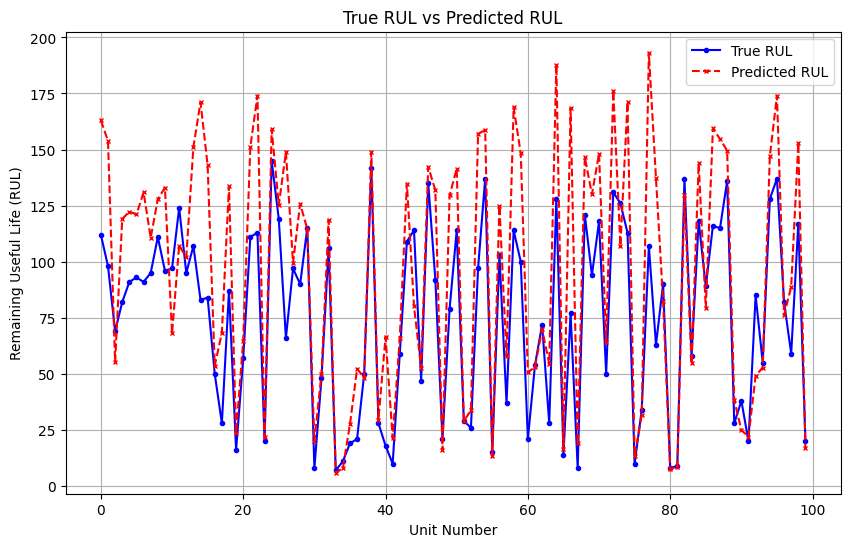

In [ ]:
# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(true_rul, label='True RUL', color='blue', linestyle='-', marker='o', markersize=3)
plt.plot(predicted_rul, label='Predicted RUL', color='red', linestyle='--', marker='x', markersize=3)
plt.xlabel('Unit Number')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title('True RUL vs Predicted RUL')
plt.legend()
plt.grid(True)
plt.show()